In [1]:
from sklearn.metrics import multilabel_confusion_matrix, classification_report, roc_curve, auc, confusion_matrix, \
     RocCurveDisplay, precision_score, recall_score, average_precision_score, PrecisionRecallDisplay, precision_recall_curve
import numpy as np
import seaborn as sns
import pandas as pd
import numpy as np
from tqdm import tqdm
import json
import torch
import os
import copy

In [2]:
from matplotlib import rc, rcParams
rc('axes', linewidth=0.5)
rc('font', size=7)
rcParams['font.family'] = 'Arial'

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
labels =['AD', 'LBD', 'VD', 'PRD', 'FTD', 'NPH', 'SEF', 'PSY', 'TBI', 'ODE']
basedir = '/home/skowshik/publication_ADRD_repo/adrd_tool/model_predictions_stripped_MNI_swinunetr'
nacc = pd.read_csv(f'{basedir}/nacc_test_with_np_cli_swinunetr_prob.csv')

In [5]:
def set_label(row, lab1, lab2):
    if row[lab1] == 1 and row[lab2] == 1:
        return 1
    # elif row[lab1] == 0 and row[lab2] == 0:
    #     return np.NaN
    return 0
    
def set_label3(row, lab1, lab2, lab3):
    if (row[lab1] == 1) and (row[lab2] == 1) and (row[lab3] == 1):
        return 1
    # elif (row[lab1] == 0) and (row[lab2] == 0) and (row[lab3] == 0):
    #     return np.NaN
    return 0

def set_prob(row, prob1, prob2):
    return row[prob1] * row[prob2]

def set_prob3(row, prob1, prob2, prob3):
    return row[prob1] * row[prob2] * row[prob3]

In [6]:
mask2 = nacc[[f'{col}_label' for col in labels]].sum(axis=1) == 2

# Use the mask to filter the DataFrame, keeping only the rows where the condition is True
filtered_nacc2 = nacc[mask2]
print(len(filtered_nacc2))

# mask3 = nacc[[f'{col}_label' for col in labels]].sum(axis=1) == 3
mask3 = nacc[[f'{col}_label' for col in labels]].apply(lambda row: row.sum() == 3, axis=1)

# Use the mask to filter the DataFrame, keeping only the rows where the condition is True
filtered_nacc3 = nacc[mask3]
print(len(filtered_nacc3))

966
202


In [7]:
filtered_nacc2[(filtered_nacc2['AD_label'] == 1) & (filtered_nacc2['ODE_label'] == 1)]

,ID,NC_label,MCI_label,DE_label,AD_label,LBD_label,VD_label,PRD_label,FTD_label,NPH_label,...,LBD_prob,VD_prob,PRD_prob,FTD_prob,NPH_prob,SEF_prob,PSY_prob,TBI_prob,ODE_prob,cdr_CDRGLOB
14,NACC226634,0,0,1,1,0,0,0,0,0,...,0.281,0.531,0.012,0.235,0.439,0.542,0.459,0.201,0.540,1.0
107,NACC257562,0,0,1,1,0,0,0,0,0,...,0.233,0.144,0.143,0.632,0.082,0.247,0.442,0.121,0.465,1.0
736,NACC295854,0,0,1,1,0,0,0,0,0,...,0.261,0.354,0.051,0.443,0.181,0.423,0.597,0.207,0.494,1.0
979,NACC489101,0,0,1,1,0,0,0,0,0,...,0.209,0.458,0.009,0.278,0.203,0.496,0.520,0.260,0.495,1.0
995,NACC496902,0,0,1,1,0,0,0,0,0,...,0.132,0.307,0.022,0.220,0.097,0.345,0.282,0.194,0.378,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7823,NACC479446,0,0,1,1,0,0,0,0,0,...,0.161,0.328,0.021,0.343,0.104,0.386,0.440,0.221,0.431,2.0
7835,NACC672941,0,0,1,1,0,0,0,0,0,...,0.170,0.532,0.011,0.179,0.100,0.315,0.354,0.142,0.420,0.5
7852,NACC611380,0,0,1,1,0,0,0,0,0,...,0.464,0.499,0.090,0.532,0.408,0.504,0.661,0.295,0.585,0.5
8615,NACC875299,0,0,1,1,0,0,0,0,0,...,0.286,0.580,0.192,0.412,0.176,0.420,0.315,0.269,0.492,0.5


### 3 etiologies

In [14]:
import copy
def get_ad_heatmap3(df_orig, auc_scores, counts):
    # counts = {}
    # auc_scores = {}
    for i, tp in enumerate(['AUROC', 'AUPR']):
        lab1 = 'AD'
        # for lab1 in labels:
        # auc_scores[tp] = {}
        for j, lab2 in enumerate(labels):
            if lab1 == lab2: 
                continue
            # auc_scores[f'{lab1}\n{lab2}\n{lab3}'] = {}
            for k, lab3 in enumerate(labels):
                df = copy.deepcopy(df_orig)
                df['label'] = np.NaN
                df['prob'] = np.NaN
                name = f'{lab1}\n{lab2}\n{lab3}'
                if f'{lab1}\n{lab2}\n{lab3}' in auc_scores[tp] or f'{lab1}\n{lab3}\n{lab2}' in auc_scores[tp]:
                    continue
                # if k <= j:
                #     continue
                # name = f'{lab2}_{lab3}'
                if lab3 == lab1 or lab3 == lab2 or lab2 == lab3: 
                    # auc_scores[tp][name] = np.NaN
                    continue
                else:
                    if len(df[(df[f"{lab1}_label"] == 1) & (df[f"{lab2}_label"] == 1) & (df[f"{lab3}_label"] == 1)]) < 25:
                        # auc_scores[tp][name] = np.NaN
                        continue
                        
                    df['label'] = df.apply(set_label3, args=(f"{lab1}_label", f"{lab2}_label", f"{lab3}_label"), axis=1)
                    df['prob'] = df.apply(set_prob3, args=(f"{lab1}_prob", f"{lab2}_prob", f"{lab3}_prob"), axis=1)
                    df = df[~df['label'].isna()]
                    print(lab2, lab3)
                    print(df['label'].value_counts())
                    try:
                        if f'{lab1}_{lab2}_{lab3}' not in counts:
                            counts[f'{lab1}_{lab2}_{lab3}'] = dict(df['label'].value_counts())
                    except:
                        counts[f'{lab1}_{lab2}_{lab3}'] = 0
                    y_true =  np.array(df['label'])
                    y_pred = np.array(df['prob'])
                    if i == 0:
                        fpr, tpr, threshhold = roc_curve(y_true=y_true, y_score=y_pred, pos_label=1, drop_intermediate=False) 
                        auc_score = auc(fpr, tpr)
                        auc_scores[tp][name] = auc_score
                    else:
                        ap = average_precision_score(y_true, y_pred)
                        auc_scores[tp][name] = ap
        
            
    return counts, auc_scores

In [15]:
counts3, auc_scores3 = get_ad_heatmap3(filtered_nacc3, auc_scores, counts)
df_auc_scores3 = pd.DataFrame(auc_scores3).T
df_auc_scores3.dropna(axis=1, how='all', inplace=True)
# df_auc_scores3.dropna(axis=0, how='all', inplace=True)

VD PSY
0    160
1     42
Name: label, dtype: int64
VD PSY
0    160
1     42
Name: label, dtype: int64


In [16]:
final_counts = {}
final_counts['1'] = {}
final_counts['0'] = {}
for k in auc_scores3['AUROC'].keys():
    final_counts['1'][k] = counts3[k.replace('\n', '_')][1]
    final_counts['0'][k] = counts3[k.replace('\n', '_')][0]
df_final_counts = pd.DataFrame(final_counts).T
df_final_counts.dropna(axis=1, how='all', inplace=True)

In [17]:
df_final_counts

,AD\nLBD,AD\nVD,AD\nFTD,AD\nSEF,AD\nPSY,AD\nODE,LBD\nPSY,FTD\nPSY,AD\nVD\nPSY
1,108,181,81,54,273,75,27,31,42
0,858,785,885,912,693,891,939,935,160


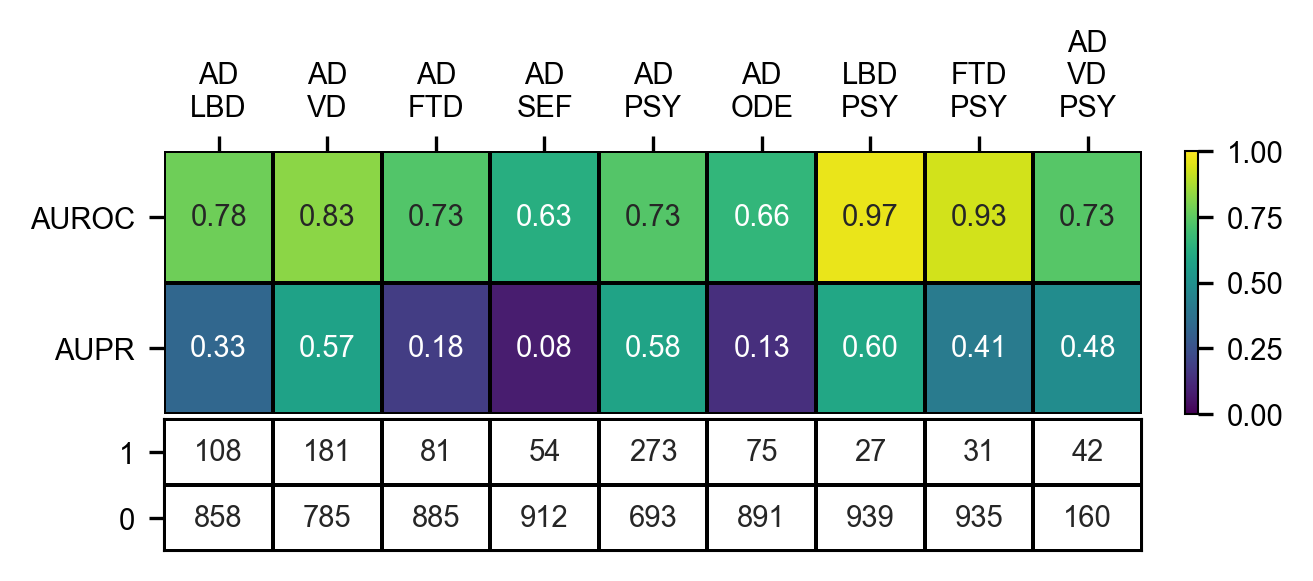

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Example DataFrame for demonstration
np.random.seed(0)
# df_auc_scores3 = pd.DataFrame(np.random.rand(10, 5), columns=['A', 'B', 'C', 'D', 'E'])

# Create a subplot structure with 2 rows
fig, axs = plt.subplots(2, 1, figsize=(4.6, 2.3), dpi=300, 
                        gridspec_kw={'height_ratios': [1, 1], 'hspace': 0.02}, 
                        sharex=False)  # Share X axis to align columns

# Plot the first heatmap with colors
sns.heatmap(df_auc_scores3, annot=True, fmt=".2f", cmap="viridis", 
            cbar=False, vmin=0, vmax=1, ax=axs[0],
            linewidths=0.5, linecolor='black')
axs[0].xaxis.tick_top()  # Move x-axis to top
plt.setp(axs[0].get_yticklabels(), rotation=0)

# Plot the second heatmap as a table-like format below
sns.heatmap(df_final_counts, annot=True, fmt=".0f", cmap=["#ffffff"], 
            cbar=False, ax=axs[1], linewidths=0.5, linecolor='black')
# axs[1].tick_params(left=False, bottom=False)  # Remove ticks
plt.setp(axs[1].get_yticklabels(), rotation=0)
axs[1].set_xticks([])# Move x-axis to top

# Ensure the bottom and right spines are visible
for spine in ['top', 'left', 'bottom', 'right']:
    axs[1].spines[spine].set_visible(True)
    axs[1].spines[spine].set_linewidth(0.5)

# Adjust font settings globally
plt.rc('font', family='Arial', size=7)  # Adjust font size as needed

pos1 = axs[0].get_position()  # Get the position of the first subplot to use as a reference
pos2 = axs[1].get_position()  # Get the current position of the second subplot

# Here, we're adjusting the second subplot's height by modifying the 'height' parameter
# For example, to make the second subplot half the height of the first:
new_height = pos1.height * 0.5
axs[1].set_position([pos2.x0, pos2.y0 + (pos2.height - new_height), pos2.width, new_height])
    
cbar = fig.colorbar(axs[0].collections[0], ax=axs, orientation='vertical', fraction=0.046, pad=0.04)

pos_ax = axs[0].get_position()
pos_cbar = cbar.ax.get_position()

# Set the colorbar's position based on the first subplot's height
cbar.ax.set_position([pos_cbar.x0, pos_ax.y0, pos_cbar.width, pos_ax.height])


plt.tight_layout()
# Save the figure
# plt.show()
plt.savefig('final_figs/fig_auc_scores_heatmap.pdf', format='pdf', dpi=300, bbox_inches='tight')
